In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [82]:
file_path = '/content/drive/My Drive/Customer-Charn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [84]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [101]:
df.isnull().sum().sum()

np.int64(0)

In [85]:
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


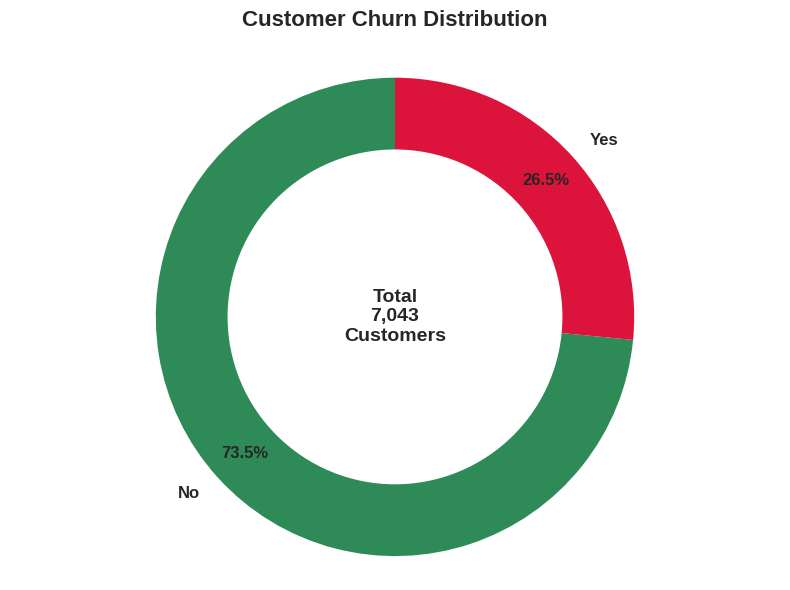

In [86]:
plt.figure(figsize=(8, 6))
churn_counts = df['Churn'].value_counts()
colors = ['#2E8B57', '#DC143C']
wedges, texts, autotexts = plt.pie(churn_counts.values,
                                   labels=churn_counts.index,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   pctdistance=0.85,
                                   textprops={'fontsize': 12, 'fontweight': 'bold'})


centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

total_customers = len(df)
plt.text(0, 0, f'Total\n{total_customers:,}\nCustomers',
         ha='center', va='center', fontsize=14, fontweight='bold')

plt.title('Customer Churn Distribution', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

The Customer Churn Distribution chart indicates that:
_______________________________________________________________________________

* 26.5% of customers have churned (i.e., stopped using the service),

* 73.5% have remained loyal,

* Out of a total of 7,043 customers.

**Inference:**
This dataset is imbalanced, with a significantly higher proportion of non-churned customers. While the churn rate of 26.5% is not negligible and warrants attention, the imbalance should be addressed during model training (e.g., using SMOTE, class weights, or resampling) to avoid bias toward the majority class.

Additionally, the churn rate suggests that over 1 in 4 customers is leaving, which may point to underlying issues in service, pricing, or support that require business intervention.

In [87]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

In [88]:
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [89]:
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(
    df[['tenure', 'MonthlyCharges', 'TotalCharges']]
)

In [90]:
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[-0.1, 12, 24, 48, 60, 72],
                           labels=['0-12', '13-24', '25-48', '49-60', '61-72'])

df = pd.get_dummies(df, columns=['TenureGroup'], drop_first=True)

service_cols = [
    'PhoneService',
    'MultipleLines_Yes',
    'OnlineSecurity_Yes',
    'OnlineBackup_Yes',
    'DeviceProtection_Yes',
    'TechSupport_Yes',
    'StreamingTV_Yes',
    'StreamingMovies_Yes'
]

existing_service_cols = [col for col in service_cols if col in df.columns]

df['ServicesCount'] = df[existing_service_cols].sum(axis=1)

In [96]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Train Set Size: (5625, 35)
Test Set Size: (1407, 35)


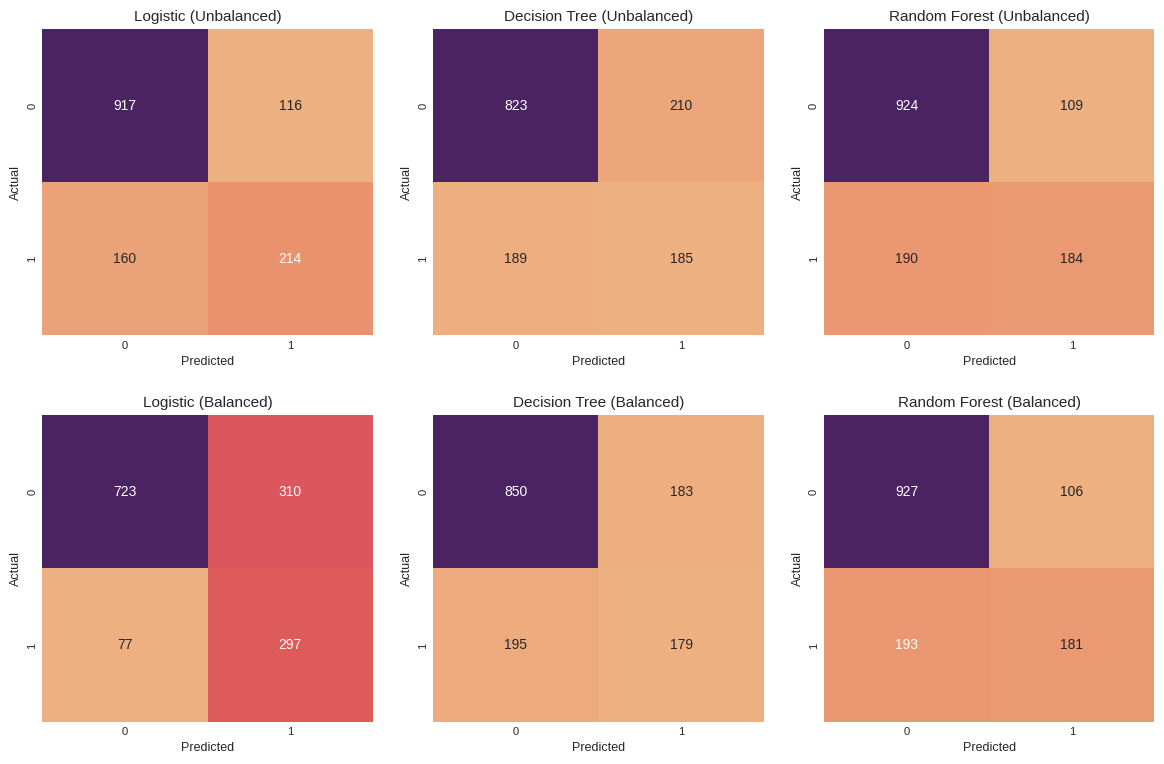

In [92]:
models = {
    "Logistic (Unbalanced)": LogisticRegression(max_iter=1000),
    "Decision Tree (Unbalanced)": DecisionTreeClassifier(),
    "Random Forest (Unbalanced)": RandomForestClassifier(random_state=42),
    "Logistic (Balanced)": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree (Balanced)": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest (Balanced)": RandomForestClassifier(class_weight='balanced', random_state=42)
}

conf_matrices = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    conf_matrices[name] = cm

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, (name, cm) in enumerate(conf_matrices.items()):
    row = idx // 3
    col = idx % 3

    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', ax=axes[row, col],
                cbar=False, annot_kws={"size": 10})
    axes[row, col].set_title(name, fontsize=11)
    axes[row, col].set_xlabel('Predicted', fontsize=9)
    axes[row, col].set_ylabel('Actual', fontsize=9)
    axes[row, col].tick_params(axis='both', labelsize=8)

plt.tight_layout(pad=2.0)
plt.show()

### Importance of Balancing the Dataset for Churn Prediction

The following confusion matrices compare the performance of three models — Logistic Regression, Decision Tree, and Random Forest — when trained on **unbalanced** vs **balanced** datasets.

---

#### 📊 Summary of Effects:

| Model              | Recall (Unbalanced) | Recall (Balanced) |
|--------------------|---------------------|--------------------|
| **Logistic**       | 214 / (214 + 160) = **57.2%**  | 297 / (297 + 77) = **79.4%** |
| **Decision Tree**  | 185 / (185 + 189) = **49.5%**  | 179 / (179 + 195) = **47.9%** |
| **Random Forest**  | 184 / (184 + 190) = **49.2%**  | 181 / (181 + 193) = **48.4%** |

---

### ✅ Key Insights:

- **Balancing improves model performance on the minority class (churned customers)**.
- **Logistic Regression** shows the largest improvement in **recall**, jumping from **57.2% to 79.4%**.
- Tree-based models (Decision Tree, Random Forest) are **less sensitive** to imbalance but still see **marginal benefits**.
- Balancing leads to a trade-off: **more false positives** in the majority class, especially in Logistic Regression (310 vs 116).

---

### 💡 Why This Matters:

- Churned customers form the **minority** but are **critical to identify** for customer retention strategies.
- Training on imbalanced data causes models to be **biased toward the majority class**, ignoring churners.
- Balancing helps models **learn patterns** from the minority class, making them more reliable for **real-world interventions**.

---


In [93]:
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
tree_model = DecisionTreeClassifier(class_weight='balanced')
forest_model = RandomForestClassifier(class_weight='balanced', random_state=42)

log_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
forest_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [94]:
models = {
    'Logistic Regression': log_model,
    'Decision Tree': tree_model,
    'Random Forest': forest_model
}

for name, model in models.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC AUC: {roc:.4f}")


Logistic Regression
[[723 310]
 [ 77 297]]
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

ROC AUC: 0.8354

Decision Tree
[[846 187]
 [189 185]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1033
           1       0.50      0.49      0.50       374

    accuracy                           0.73      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.73      0.73      0.73      1407

ROC AUC: 0.6573

Random Forest
[[927 106]
 [193 181]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                  

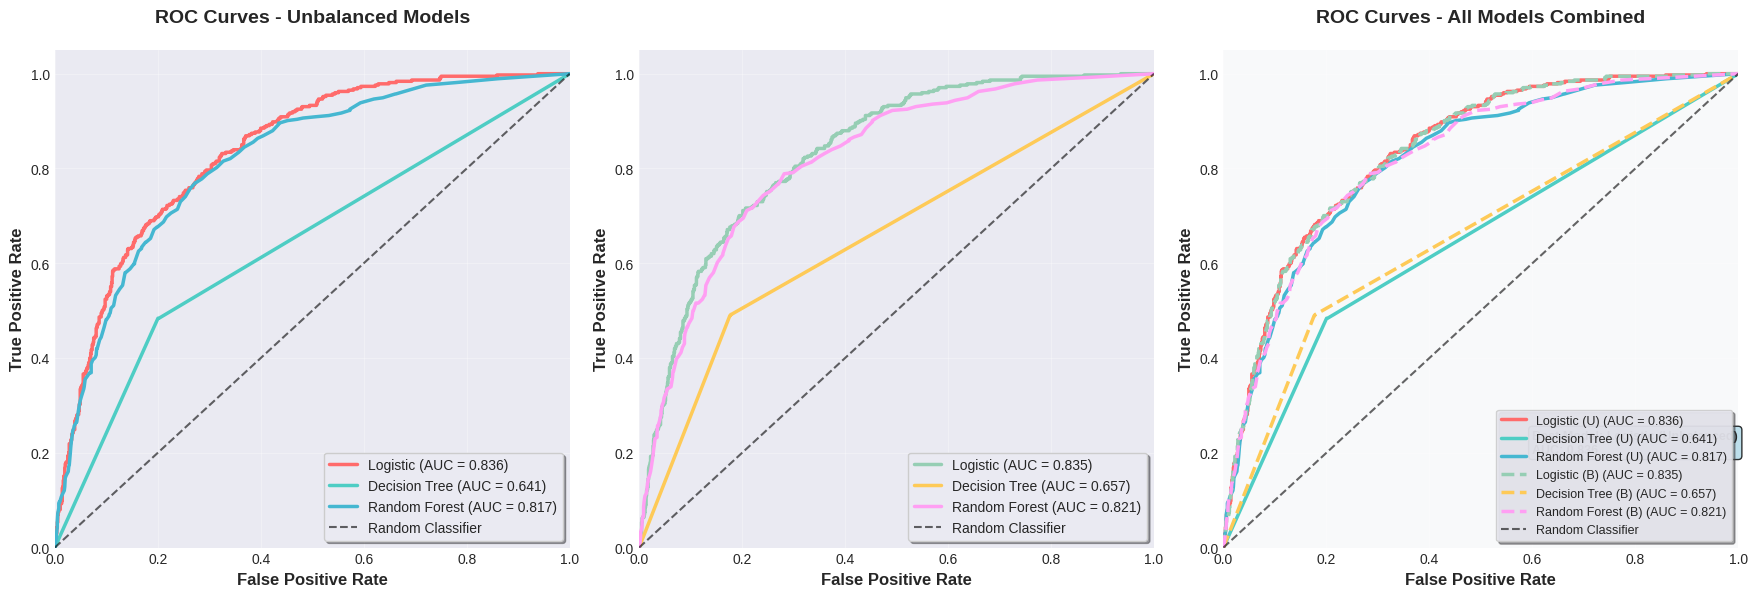

In [95]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
colors_unbalanced = ['#FF6B6B', '#4ECDC4', '#45B7D1']
colors_balanced = ['#96CEB4', '#FECA57', '#FF9FF3']
all_colors = colors_unbalanced + colors_balanced


models = {
    "Logistic (Unbalanced)": LogisticRegression(max_iter=1000),
    "Decision Tree (Unbalanced)": DecisionTreeClassifier(),
    "Random Forest (Unbalanced)": RandomForestClassifier(random_state=42),
    "Logistic (Balanced)": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree (Balanced)": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest (Balanced)": RandomForestClassifier(class_weight='balanced', random_state=42)
}

for name, model in models.items():
    if not hasattr(model, 'classes_'):
        model.fit(X_train, y_train)

unbalanced_models = {k: v for k, v in models.items() if 'Unbalanced' in k}
for idx, (name, model) in enumerate(unbalanced_models.items()):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax1.plot(fpr, tpr, color=colors_unbalanced[idx], lw=2.5,
             label=f'{name.replace(" (Unbalanced)", "")} (AUC = {roc_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.6, lw=1.5, label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curves - Unbalanced Models', fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)

balanced_models = {k: v for k, v in models.items() if 'Balanced' in k}
for idx, (name, model) in enumerate(balanced_models.items()):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ax2.plot(fpr, tpr, color=colors_balanced[idx], lw=2.5,
             label=f'{name.replace(" (Balanced)", "")} (AUC = {roc_auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.6, lw=1.5, label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)

linestyles = ['-', '-', '-', '--', '--', '--']

for idx, (name, model) in enumerate(models.items()):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    line_style = linestyles[idx]
    display_name = name.replace(" (Unbalanced)", "").replace(" (Balanced)", "")
    if "Unbalanced" in name:
        display_name += " (U)"
    else:
        display_name += " (B)"

    ax3.plot(fpr, tpr, color=all_colors[idx], lw=2.5, linestyle=line_style,
             label=f'{display_name} (AUC = {roc_auc:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.6, lw=1.5, label='Random Classifier')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax3.set_title('ROC Curves - All Models Combined', fontsize=14, fontweight='bold', pad=20)
ax3.legend(loc="lower right", fontsize=9, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
ax3.set_facecolor('#f8f9fa')

best_auc = 0
best_model = ""
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    current_auc = auc(fpr, tpr)
    if current_auc > best_auc:
        best_auc = current_auc
        best_model = name

ax3.text(0.6, 0.2, f'Best Model: {best_model}\nAUC: {best_auc:.3f}',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
         fontsize=9, fontweight='bold')

ax3.grid(True, alpha=0.3)



plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Insights from ROC Curves

The ROC curves compare model performance on **unbalanced** and **SMOTE-balanced** datasets across three classifiers: Logistic Regression, Decision Tree, and Random Forest.

---

### 🔍 AUC (Area Under Curve) Comparison:

| Model              | AUC (Unbalanced) | AUC (Balanced) |
|--------------------|------------------|----------------|
| **Logistic**       | 0.836            | 0.835          |
| **Decision Tree**  | 0.641            | 0.657          |
| **Random Forest**  | 0.817            | 0.821          |

---

### ✅ Key Observations:

- **Logistic Regression**: Slight decrease in AUC, but SMOTE significantly improved **recall**, as seen in the confusion matrix. This means more **true churners** were caught, despite a minimal AUC change.
  
- **Decision Tree**: AUC improved from **0.641 → 0.657**, showing that balancing **helped generalize better** on minority class (churn).

- **Random Forest**: Already performed well, but AUC still slightly improved from **0.817 → 0.821**.

- In the combined ROC plot, **SMOTE-balanced models (dashed lines)** tend to stay closer to the **top-left corner**, indicating **better trade-offs** between TPR and FPR.

---

### 💡 Why SMOTE Is Necessary:

- In imbalanced datasets, models **bias toward the majority class**, leading to poor detection of minority class (churned customers).
  
- **SMOTE (Synthetic Minority Over-sampling Technique)** generates synthetic samples for the minority class, allowing the model to **learn minority patterns** more effectively.

- This improves **recall** and **balanced accuracy**, even if AUC changes are small — especially valuable in **churn prediction**, where catching churners is crucial.

---

### 🧠 Conclusion:

- Even with minimal AUC gains, **SMOTE improves the real-world utility** of models by identifying more churners.
- It is especially beneficial for **linear models like Logistic Regression**, and marginally helps tree-based models.


Top 10 features - Logistic Regression:
Contract_Two year                 1.458611
tenure                            1.256580
InternetService_Fiber optic       1.141471
Contract_One year                 0.789476
TotalCharges                      0.607900
MonthlyCharges                    0.496635
PaymentMethod_Electronic check    0.407221
PhoneService                      0.392077
StreamingTV_Yes                   0.385556
StreamingMovies_Yes               0.371355
dtype: float64


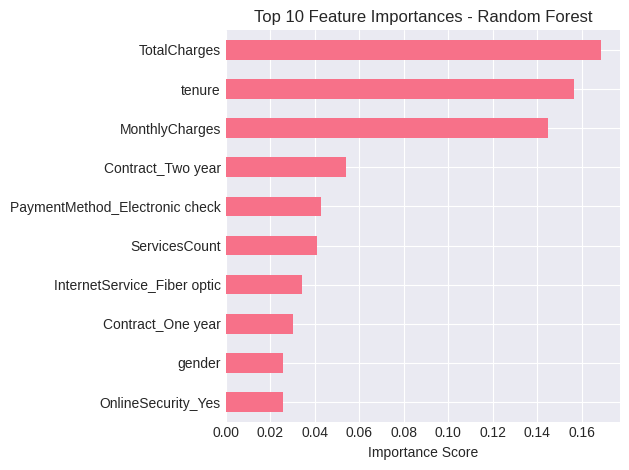

In [75]:
coef_series = pd.Series(log_model.coef_[0], index=X.columns)
print("Top 10 features - Logistic Regression:")
print(coef_series.abs().sort_values(ascending=False).head(10))

importances = pd.Series(forest_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [97]:
!pip install imbalanced-learn

In [98]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [99]:
log_model_smote = LogisticRegression(max_iter=1000)
dt_model_smote = DecisionTreeClassifier()
rf_model_smote = RandomForestClassifier(random_state=42)

log_model_smote.fit(X_train_resampled, y_train_resampled)
dt_model_smote.fit(X_train_resampled, y_train_resampled)
rf_model_smote.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [100]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

for name, model in {
    'Logistic (SMOTE)': log_model_smote,
    'Decision Tree (SMOTE)': dt_model_smote,
    'Random Forest (SMOTE)': rf_model_smote
}.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

--- Logistic (SMOTE) ---
Confusion Matrix:
 [[789 244]
 [120 254]]
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.51      0.68      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407

ROC AUC: 0.8192883507358764
--- Decision Tree (SMOTE) ---
Confusion Matrix:
 [[776 257]
 [161 213]]
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1033
           1       0.45      0.57      0.50       374

    accuracy                           0.70      1407
   macro avg       0.64      0.66      0.65      1407
weighted avg       0.73      0.70      0.71      1407

ROC AUC: 0.6603643921706673
--- Random Forest (SMOTE) ---
Confusion Matrix:
 [[834 199]
 [130 244]]
              precision    recall  f1-score   support

           0       0.87 

**SMOTE is not one-size-fits-all.**

------------------------------------------------





*   Logistic Reg:	❌ No	Reduced recall ----  linear model hurt
*   Decision Tree	🤷‍♂️ Maybe	Slight recall gain ---- overall weak

*  Random Forest	✅ Yes	Good balance -----  recall , F1 ↑





<class 'numpy.ndarray'>
(1407, 35, 2)


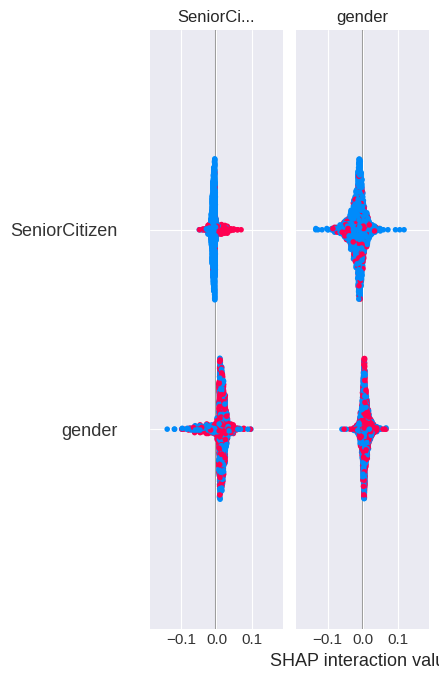

In [106]:
import shap

explainer = shap.TreeExplainer(forest_model)

shap_values = explainer.shap_values(X_test)

print(type(shap_values))
print(np.shape(shap_values))

if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)


* The left plot focuses on the interaction of SeniorCitizen with itself and gender, while the right plot emphasizes gender with itself and SeniorCitizen.
* If the arms extend far from zero (e.g., ±0.1), it suggests a significant interaction effect. Short arms near zero indicate minimal interaction.
* The color gradient helps identify how the value of one feature (e.g., gender) modifies the effect of the other (e.g., SeniorCitizen) on the outcome.

In [108]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f9bcddb06ea76869387277d1bb82435ee32790b6a4963b62bf8381826daf0355
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [109]:
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='classification'
)

instance = X_test.iloc[0].values
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=forest_model.predict_proba
)

exp.show_in_notebook()

Contract_Two year had the biggest positive influence on predicting class 0.

tenure > 0.96 also nudged the prediction toward class 0 (longer tenure = likely no churn).

Contract_One year <= ... implies the customer doesn't have a one-year contract, which also favored class 0.

In [115]:
import joblib
joblib.dump(X_train.columns.tolist(), "feature_names.pkl")
joblib.dump(log_model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
feature_names = joblib.load("feature_names.pkl")